## Setup imports

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..")))

import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn import cluster
from analysis.entropy import *
from analysis.analysis_utils import Mouse, find_file
from analysis.resampling import Resampler
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from IPython.core.interactiveshell import InteractiveShell

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

##### We load & preprocess the data for a mouse.

In [3]:
s = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_S.csv"), header=None)
c = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_C.csv"), header=None)
behavior = pd.read_csv(find_file("Hen_Lab/Mice", "drd218_EPM_Behavior.csv"), header=None)

# Reindex neuron column vectors from 0,1,2,...,n ---> 1,2,3,...,n,n+1
s.columns = [col+1 for col in s.columns]
c.columns = [col+1 for col in c.columns]

behavior_column_names = ['Trial_time',
                         'Recording_time',
                         'X_center',
                         'Y_center',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1_centerpoint',
                         'Open2_centerpoint',
                         'Closed1_centerpoint',
                         'Closed2_centerpoint',
                         'OpenArms_centerpoint',
                         'ClosedArms_centerpoint',
                         'Hardware_command',
                         'Hardware_command_2',
                         'Hardware_command_3',
                         'Hardware_command_4',
                         'Result_1']

# Drop every 3rd row from the behavior dataframe
behavior = Mouse.downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Downsample s (spikes) from 20 fps --> 10 fps: 
# We add a time series column using Timedelta, where the amount of periods is the current
# total amount of frames in the dataframe. 20 fps implies 50 milliseconds per frame, so
# we specify each period to be 50 milliseconds (ms) long.
s = s.assign(Trial_time=pd.timedelta_range(0, periods=len(s.index), freq="50ms"))

# Finally, we downsample the dataframe into 100 millisecond bins (since 10 fps implies 100 ms per frame). 
# We take the average of the values of the timestamps falling into a bin.
s = s.resample("100ms", on="Trial_time").mean()

# Drop the 'Trial_time' time series index, and reset the index by enumerating the frames.
s.reset_index(drop=True, inplace=True)

# Create a Mouse object to store all of the data for a particular mouse
drd218 = Mouse(cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd218.spikes = drd218.spikes.where(drd218.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (drd218.spikes_and_beh["OpenArms_centerpoint"]) + (drd218.spikes_and_beh["ClosedArms_centerpoint"])
center = 1-center
drd218.spikes_and_beh["Center"] = center

## Cell Selectivity

##### Use the `shuffle` function in order to create a permutation distribution, for each neuron, of the difference of means.

In [4]:
%time permutation_distributions_dataframe = Resampler.shuffle(10000, drd218, "OpenArms_centerpoint", "ClosedArms_centerpoint")

CPU times: user 17.7 ms, sys: 26.2 ms, total: 43.9 ms
Wall time: 13.2 s


##### Plot the permutation distributions

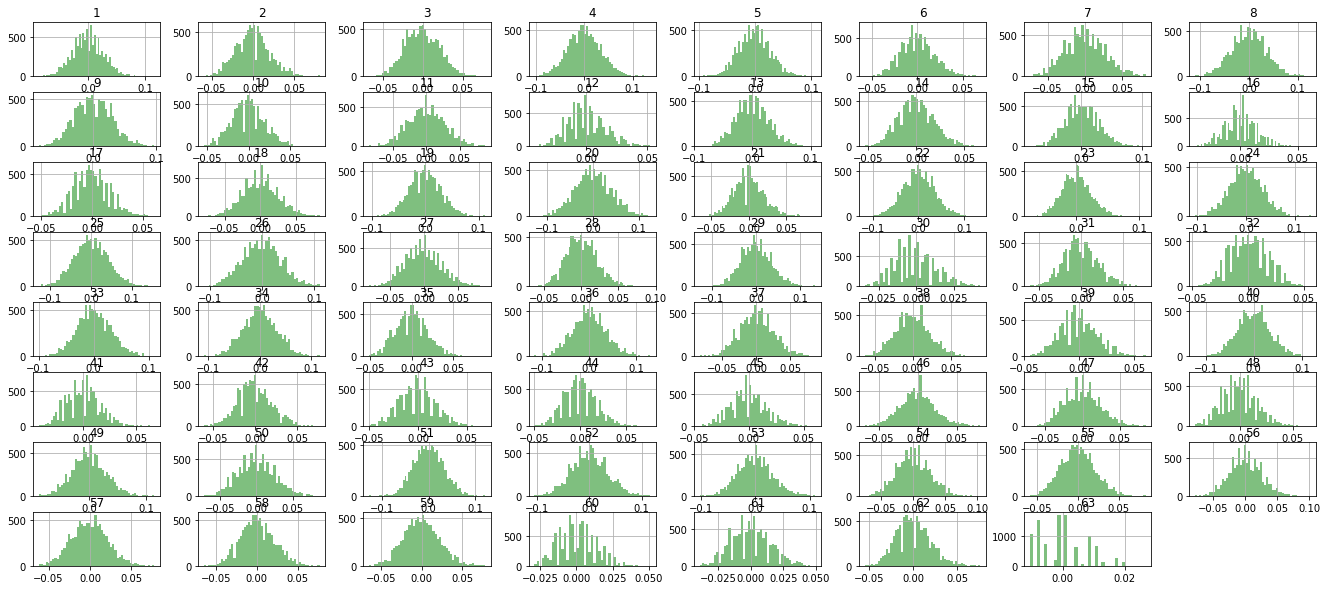

In [5]:
permutation_distributions_dataframe.hist(alpha=0.5, color="green", bins="auto", figsize=(23, 10));

##### Classify cells by the behavior for which they are selective.

In [6]:
original_diff_of_means = dict(zip(drd218.spikes.columns, Resampler.compute_diff_rate(drd218, "OpenArms_centerpoint", "ClosedArms_centerpoint")))
selectivity_dictionary = Resampler.non_normal_neuron_classifier(permutation_distributions_dataframe, original_diff_of_means, p_value=0.05)
classified_cells_dict = Resampler.classify_by_behavior(selectivity_dictionary, original_diff_of_means,"OpenArms_centerpoint", "ClosedArms_centerpoint")

##### Plot a pie chart in order to visualize the proportions of cells that are selective for behaviors of interest.

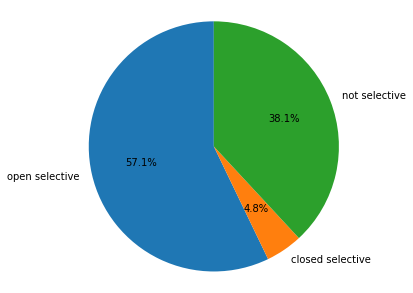

In [7]:
open_selective = 0
closed_selective = 0
not_seletive = 0

for cell in classified_cells_dict:
    if classified_cells_dict[cell] == "OpenArms_centerpoint":
        open_selective += 1
    elif classified_cells_dict[cell] == "ClosedArms_centerpoint":
        closed_selective += 1
    elif classified_cells_dict[cell] == "not-selective":
        not_seletive += 1
        
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["open selective", "closed selective", "not selective"]
sizes = [open_selective, closed_selective, not_seletive]
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
ax1.axis('equal') 
plt.show();

## Clustering

##### The functions below are stand-alone functions meant to help with clustering analysis.

In [8]:
def affinity_propagation(similiarity_matrix):
    """Perform Affinity Propagation Clustering of data
    
    Note: This function is a wrapper for AffinityPropagation from scikit-learn
    Source: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html

    Args:
        similarity_matrix: array-like, shape (n_samples, n_samples)
            Matrix of similarities between points.
    
    Returns:
        clusters: dictionary
            A dictionary of <neuron: cluster label> key-value pairs.
    """
    clusters = {}
    
    labels = cluster.AffinityPropagation().fit_predict(X)
    n_labels = labels.max()

    clusters = {}
    for i in range(n_labels+1):
        for neuron in list(similiarity_matrix.columns[labels==i]):
            clusters[neuron] = i
            
    return clusters

def extract_clusters(clusters): 
    """Extract all the clusters into a dictionary of lists.
    
    This function takes in a dictionary of <neuron: cluster label>
    key-value pairs and produces a dictionary of <cluster label: neurons>
    
    """
    extracted_clusters = {}

    for neuron, cluster_label in clusters.items():
        if extracted_clusters.get(cluster_label, None):
            extracted_clusters[cluster_label].append(neuron)
        else:
            extracted_clusters[cluster_label] = [neuron]

    return extracted_clusters

def compute_nmi(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        H_x = entropy(dataframe[neuron_pair[0]].values)
        H_y = entropy(dataframe[neuron_pair[1]].values)
        if 0.5 * (H_x + H_y) == 0:
            nmi = 0
            connections[neuron_pair] = nmi
        else:
            nmi = entropy_cc(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)
            connections[neuron_pair] = nmi
        
    return connections

def compute_corrcoef(dataframe):
    connections = {}
    
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        if dataframe[neuron_pair[0]].std() == 0 or dataframe[neuron_pair[1]].std() == 0:
            continue

        corrcoef = np.corrcoef(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)[0][1]
        if corrcoef >= 0:
            connections[neuron_pair] = corrcoef
        
    return connections

def nmi_matrix(dataframe):
    nmi_df = pd.DataFrame(columns=dataframe.columns, index=dataframe.columns)
    for neuron_pair in itertools.combinations(dataframe.columns, 2):
        H_x = entropy(dataframe[neuron_pair[0]].values)
        H_y = entropy(dataframe[neuron_pair[1]].values)
        if 0.5 * (H_x + H_y) == 0:
            nmi = 0
        else:
            nmi = entropy_cc(dataframe[neuron_pair[0]].values, dataframe[neuron_pair[1]].values)
        
        nmi_df.iat[neuron_pair[0]-1, neuron_pair[1]-1] = nmi
        nmi_df.iat[neuron_pair[1]-1, neuron_pair[0]-1] = nmi
    
    nmi_df.fillna(0, inplace=True)
    return nmi_df

def plot_traces(clusters, mouse, **kwargs):
    figsize = kwargs.get("figsize", (15, 6))
    hspace = kwargs.get("hspace", 0.0)
    file_name = kwargs.get("file_name", "neural_traces.png")
    total_subplots = 0
    
    for cluster in clusters:
        if len(clusters[cluster]) > 1:
            total_subplots += len(clusters[cluster])
            
    cmap = get_cmap(max(clusters.keys())+1, name="Dark2")
    fig, ax = plt.subplots(total_subplots, 1, figsize=figsize)
    
    all_frames = []
    all_frames.append(get_continuous_beh_indices(mouse, "Center", framerate=1, num_of_sec=1))
    all_frames.append(get_continuous_beh_indices(mouse, "OpenArms_centerpoint", framerate=1, num_of_sec=1))
    all_frames.append(get_continuous_beh_indices(mouse, "ClosedArms_centerpoint", framerate=1, num_of_sec=1))
    all_frames.append(get_continuous_beh_indices(mouse, "Head_Dips", framerate=1, num_of_sec=1))
    
    ax_index = 0
    dataframe = mouse.cell_transients
    background_colors = ["red", "orange", "lightcyan", "grey"]
    
    for cluster in clusters:
        if len(clusters[cluster]) > 1:
            for index in range(0, len(clusters[cluster])):
                ax[ax_index].plot(dataframe.index, dataframe[clusters[cluster][index]], c=cmap(cluster), lw=2)
                for i, frames in enumerate(all_frames):
                    for time_period in frames:
                        ax[ax_index].axvspan(time_period[0], time_period[1], alpha=0.1, color=background_colors[i])
                        ax[ax_index].axis("off")
                ax_index += 1
            
    plt.subplots_adjust(wspace=0, hspace=hspace)
    
    if kwargs.get("save", False):
        plt.savefig(file_name, dpi=300)
        
    plt.show();
    
def get_cmap(n, name="tab20"):
    """ Returns a function that maps each index in 0,1,...,n-1 
        to a distinct RGB color; the keyword argument name must 
        be a standard mpl colormap name.
    """
    return plt.cm.get_cmap(name, n)

def get_continuous_beh_indices(mouse, behavior, **kwargs):
    """Find all frames of continuous behavior
    """
    indices = []
    continuous_beh = {}
    num_of_sec = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)

    for row in mouse.spikes_and_beh.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= num_of_sec * framerate:
                
                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]
                indices.append((begin, end))

            continuous_beh.clear()
                
    return indices

def get_neuron_positions(neuron_network, coordinates_df):
    """Create a dictionary of all the neuron cartestian coordinates
    """
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

##### We load & preprocess all the data for another mouse.

In [9]:
c = pd.read_csv(find_file("Hen_Lab/Mice", "Drd87_EPM_C_thresh.csv"), header=None)
s = pd.read_csv(find_file("Hen_Lab/Mice", "Drd87_EPM_S_thresh.csv"), header=None)
behavior = pd.read_csv(find_file("Hen_Lab/Mice", "DRD87_EPM_NEW_BEH.csv"), header=None)

# Reindex neuron column vectors from 0,1,2,...,n ---> 1,2,3,...,n,n+1
s.columns = [col+1 for col in s.columns]
c.columns = [col+1 for col in c.columns]

behavior_column_names = ['Trial_time',
                         'Recording_time',
                         'X_center',
                         'Y_center',
                         'Area',
                         'Areachange',
                         'Elongation',
                         'Distance_moved',
                         'Velocity',
                         'Arena_centerpoint',
                         'Open1_centerpoint',
                         'Open2_centerpoint',
                         'Closed1_centerpoint',
                         'Closed2_centerpoint',
                         'OpenArms_centerpoint',
                         'ClosedArms_centerpoint',
                         'Hardware_command',
                         'Hardware_command_2',
                         'Hardware_command_3',
                         'Hardware_command_4',
                         'Result_1',
                         "Head_Dips"]

# Drop every 3rd row from the behavior dataframe 
behavior = Mouse.downsample_dataframe(behavior, 3)

# Rename the behavior dataframe columns and drop all useless column vectors.
behavior.columns = behavior_column_names
behavior.drop(["Hardware_command", "Hardware_command_2", "Hardware_command_3", "Hardware_command_4", "Result_1"], axis=1, inplace=True)

# Create a Mouse object to store all of the data for a particular mouse
drd87 = Mouse(cell_transients=c, spikes=s, behavior=behavior)

# Convert dataframe to a boolean matrix, where spikes := 1 and no spike := 0
drd87.spikes = drd87.spikes.where(drd87.spikes==0, 1)

# Add "Center" column to concatenated dataframe
center = (drd87.spikes_and_beh["OpenArms_centerpoint"]) + (drd87.spikes_and_beh["ClosedArms_centerpoint"])
center = 1-center
drd87.spikes_and_beh["Center"] = center

##### We read in the cartesian coordinates of drd87's neurons, as imaged.

In [10]:
coordinates = pd.read_csv(find_file("Hen_Lab/Mice", "EPM_NO_OFT_POPP_centroids.csv"), header=None)
coordinates.columns = ['x', 'y']

# Reset the index so that it starts from 1, since it is more natural to enumerate neurons as 1, 2, ..., n
coordinates.index = pd.RangeIndex(1, len(coordinates.index)+1)

##### We find all possible clusters of neurons for drd87 in EPM during the overall session. 

In [11]:
# connections = compute_corrcoef(drd87.auc_df)
connections = compute_nmi(drd87.spikes)
drd87_graph = NeuronNetwork(drd87.spikes.columns, connections)
pos = get_neuron_positions(drd87_graph, coordinates)
  
# X = drd87.auc_df.corr().where(drd87.auc_df.corr() >= 0, 0)
X = nmi_matrix(drd87.spikes)
clusters = affinity_propagation(X)

##### We plot the imaged neurons by their actual positions, and we color code each neuron by its respective cluster.

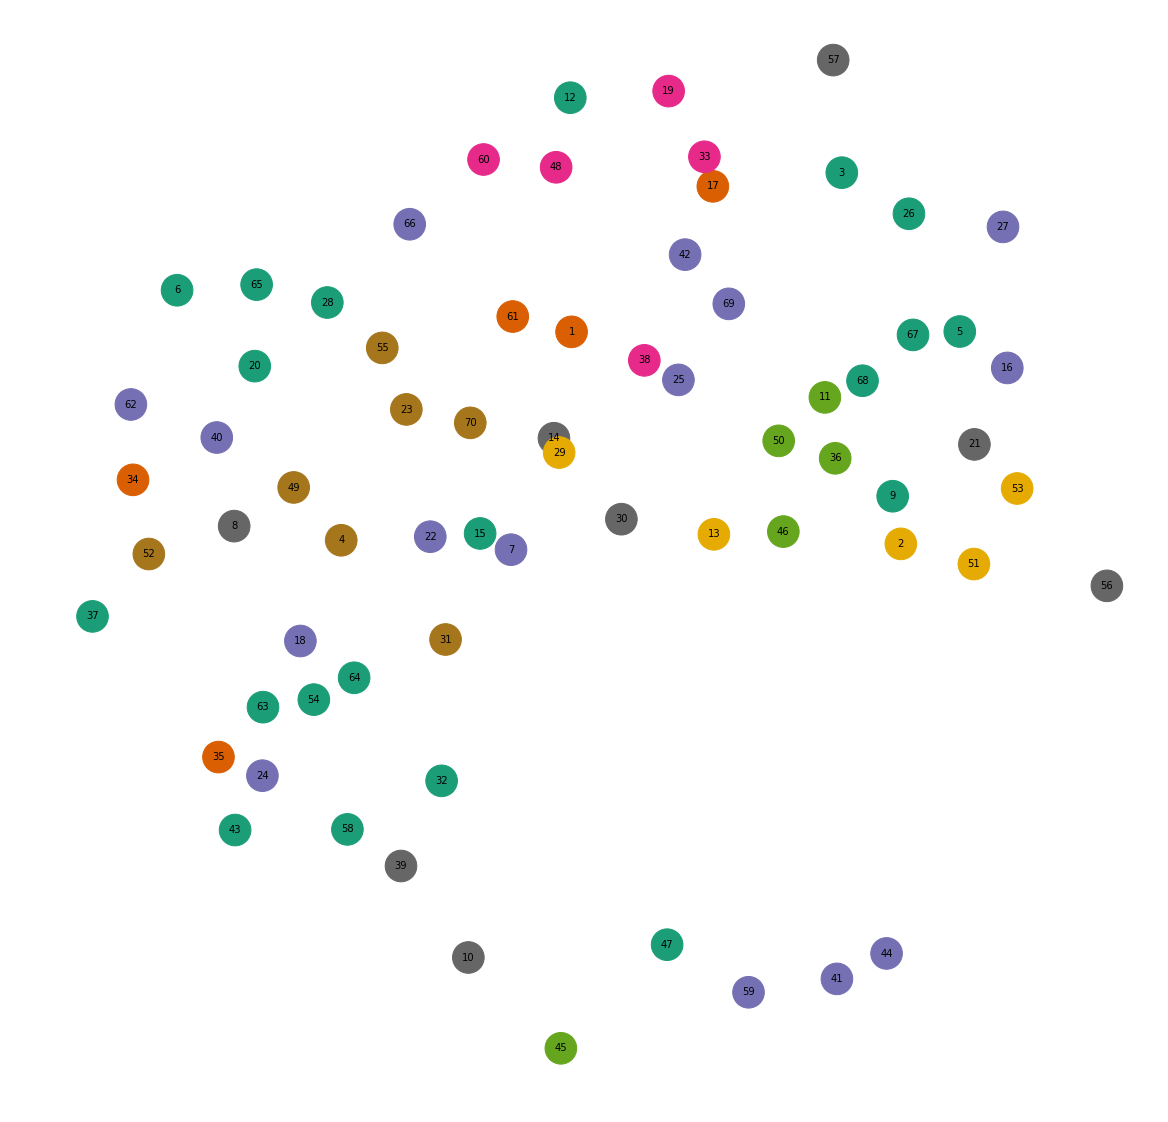

In [12]:
node_colors = [clusters[key] for key in sorted(clusters.keys())]
drd87_graph.plot(pos=pos, node_colors=node_colors, figsize=(20,20), node_size=1000, draw_edges=False, save=False, file_name="drd87_overall_nmi.png")

##### We plot the continuous time series plots, for each neuron that was assigned to a cluster with $2$ or more neurons. Each time series plot is color coded its respective cluster. 

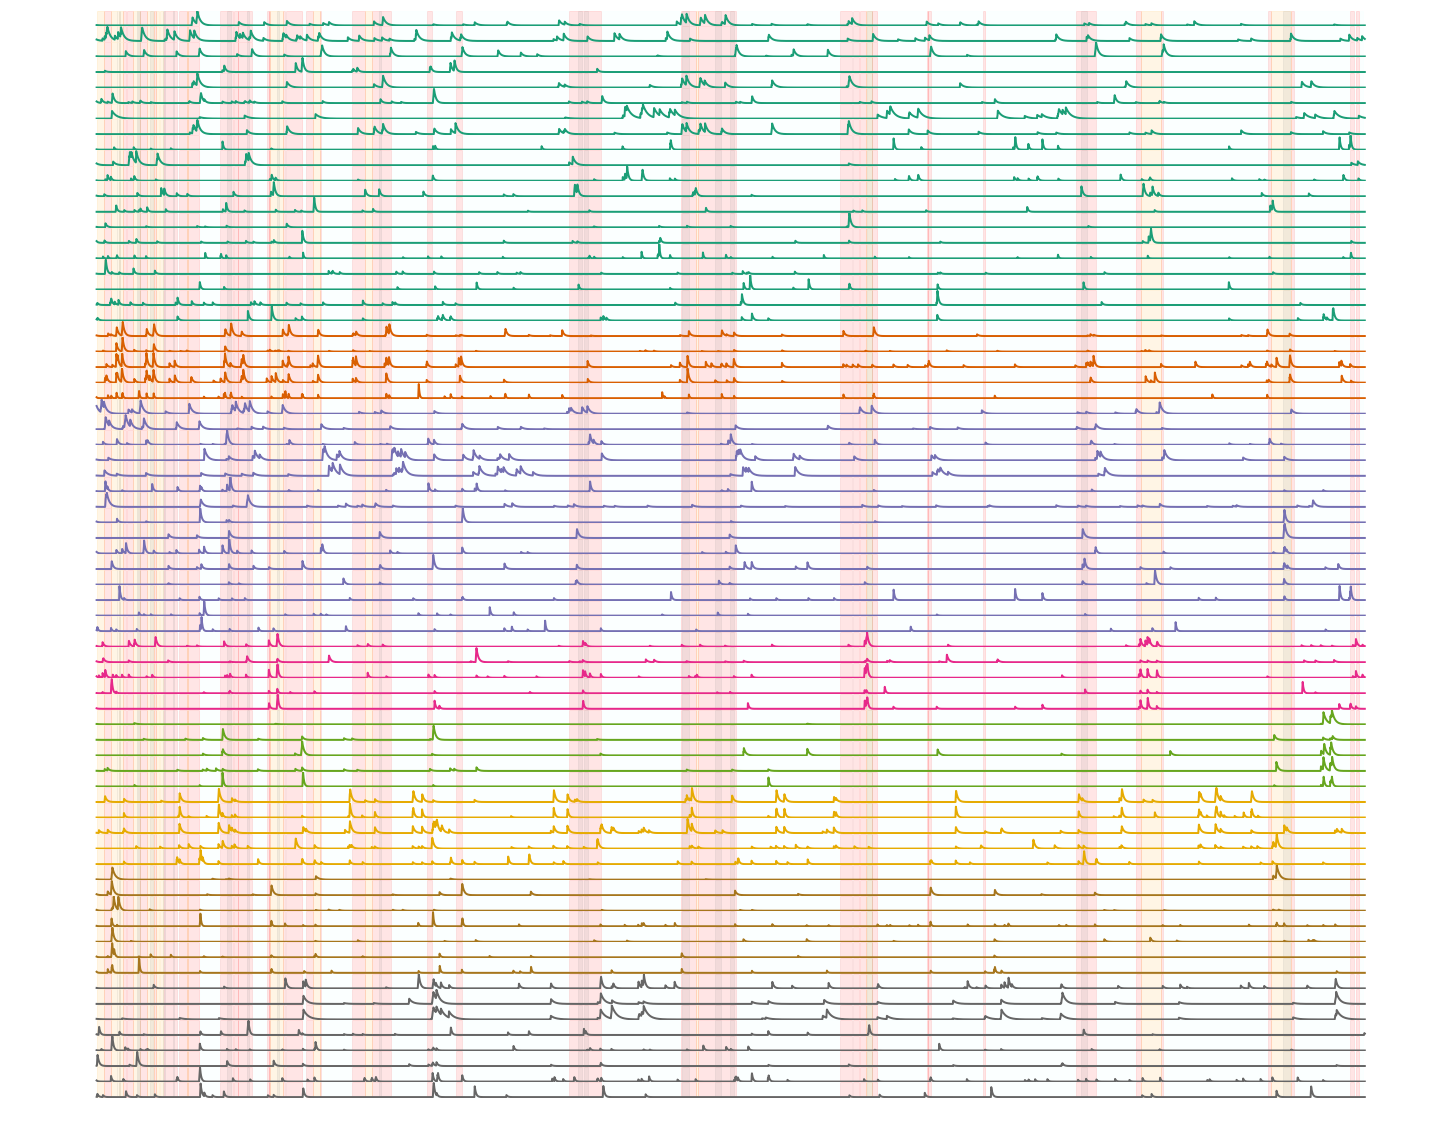

In [13]:
clusters = extract_clusters(clusters)
plot_traces(clusters, drd87, figsize=(25, 20), hspace=0.0, save=False, file_name="drd87_cluster_traces.png")